A notebook to explore how well astrometry performs on a single night. Check the RMS of object centroid as a function of SNR.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
from lsst.daf.persistence import Butler
from lsst.afw.table import MultiMatch

In [3]:
# Handy function for later. 
# Stolen from lsst.sims.maf.utils. Should probably go to a more general library.
def gnomonic_project_toxy(RA1, Dec1, RAcen, Deccen):
    """
    Calculate the x/y values of RA1/Dec1 in a gnomonic projection with center at RAcen/Deccen.

    Parameters
    ----------
    RA1 : numpy.ndarray
        RA values of the data to be projected, in radians.
    Dec1 : numpy.ndarray
        Dec values of the data to be projected, in radians.
    RAcen: float
        RA value of the center of the projection, in radians.
    Deccen : float
        Dec value of the center of the projection, in radians.

    Returns
    -------
    numpy.ndarray, numpy.ndarray
        The x/y values of the projected RA1/Dec1 positions.
    """
    cosc = np.sin(Deccen) * np.sin(Dec1) + np.cos(Deccen) * np.cos(Dec1) * np.cos(RA1-RAcen)
    x = np.cos(Dec1) * np.sin(RA1-RAcen) / cosc
    y = (np.cos(Deccen)*np.sin(Dec1) - np.sin(Deccen)*np.cos(Dec1)*np.cos(RA1-RAcen)) / cosc
    return x, y


In [4]:
# set up a butler
butler = Butler('/project/shared/data/Twinkles_subset/output_data_v2')

/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [5]:
# This is pulling the initial WCS fit. In the future, will want to use jointcal results.
subset = butler.subset('src', filter='r')

In [6]:
# Copy pasta from matching notebook. Presumably, using jointcal would already have things matched up
matched_cat = None
calexps = {}
for data_ref in subset:
    data_id = data_ref.dataId
    src_cat = data_ref.get('src')
    calexps[data_id['visit']] = data_ref.get('calexp')
    if matched_cat is None:
        id_fmt = {'visit':np.int64}
        # Using default 0.5 arcsec radius
        matched_cat = MultiMatch(src_cat.schema, id_fmt)
    matched_cat.add(src_cat, data_id)
final_catalog = matched_cat.finish()

In [7]:
# Find the unique object IDs
object_ids = final_catalog.get('object')
unique_object_ids = np.unique(object_ids)

In [8]:
unique_object_ids

array([   1,    2,    3, ..., 6696, 6697, 6698], dtype=int64)

In [9]:
# For each unique object, want to know the

In [10]:
final_catalog

<class 'lsst.afw.table.source.source.SourceCatalog'>
      id           coord_ra           coord_dec       ... object visit
                     rad                 rad          ...             
------------- ------------------ -------------------- ... ------ -----
 988882665473 0.9235074520228211  -0.4766365244228648 ...      1   230
 988882665474  0.923440817814142 -0.47691936249744354 ...      2   230
 988882665475 0.9234075343436854  -0.4770033201661779 ...      3   230
 988882665476 0.9227891880394103 -0.47936484621963726 ...      4   230
 988882665477 0.9227211251615833  -0.4796207587219972 ...      5   230
 988882665478 0.9226835125005866  -0.4797644474181495 ...      6   230
 988882665479 0.9231775946204576 -0.47789024798034624 ...      7   230
1001767567613 0.9231778259833596  -0.4778902460626018 ...      7   233
1010357502194 0.9231776163406615 -0.47789030940973437 ...      7   235
1023242404072 0.9231782648808977 -0.47789014784112605 ...      7   238
          ...           

In [26]:
# array to hold stats for each object we have matched up
names = ['id', 'flux', 'flux_err', 'ra_rms_arcsec', 'dec_rms_arcsec']
dtypes = [int, float, float, float, float]
results = np.zeros(len(unique_object_ids), dtype=list(zip(names, dtypes)))

In [27]:

for i,obj_id in enumerate(unique_object_ids):
    idx = np.where(final_catalog.get('object')==obj_id)[0]
    # only ones where we have enough observations to do stats
    if np.size(idx) > 3:
        # pull out the ra and dec (these are in radians)
        ra = final_catalog.get('coord_ra')[idx]
        dec = final_catalog.get('coord_dec')[idx]
        x,y = gnomonic_project_toxy(ra, dec, ra[0], dec[0])
        results['id'][i] = obj_id
        results['ra_rms_arcsec'][i] = np.std(np.degrees(x)*3600.)
        results['dec_rms_arcsec'][i] = np.std(np.degrees(y)*3600.)
# crop off the rows we skipped
results = results[np.where(results['id'] != 0)]

array([0.0594606 , 0.01751762, 0.09431436, ..., 0.14578818, 0.07584487,
       0.11900335])

In [20]:
obj_id = 12
idx = np.where(final_catalog.get('object')==obj_id)[0]

In [32]:
ra = final_catalog.get('coord_ra')[idx]
dec = final_catalog.get('coord_dec')[idx]
x,y = gnomonic_project_toxy(ra, dec, ra[0], dec[0])

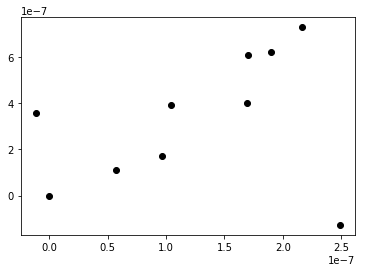

In [34]:
plt.plot(x,y, 'ko')

0.05548774156439943